# Step 4: Building Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

# Graphics in SVG format are more sharp and legible
#%config InlineBackend.figure_format = 'svg'
#ignore warning messages 
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

In [3]:
spotify_model = pd.read_csv('scaled_spotify_data_model.csv')
spotify_model_ohe = pd.read_csv('ohe_scaled_spotify_data_model.csv')
spotify_original = pd.read_csv("dataset.csv")

In [4]:
spotify_original

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
113996,113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
113997,113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
113998,113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


In [5]:
# scaler was turning some values into NAN because didnt reset index
spotify_original = spotify_original.dropna()
spotify_original = spotify_original.drop(['Unnamed: 0','duration_ms', 'explicit', 'time_signature'], axis=1)

In [6]:
spotify_original = spotify_original.reset_index()

In [7]:
spotify = spotify_original.copy()
spotify['Genre_Combined'] = spotify.groupby(['track_id'])['track_genre'].transform(lambda x: ','.join(x))
spotify['Genre_Combined'] = spotify['Genre_Combined'].str.split(',')
spotify = spotify.drop_duplicates(subset=['track_id'])
spotify = spotify.drop_duplicates(subset=['track_name'])
spotify = spotify.reset_index()

In [8]:
numerical = spotify.select_dtypes(include='number').columns.tolist()

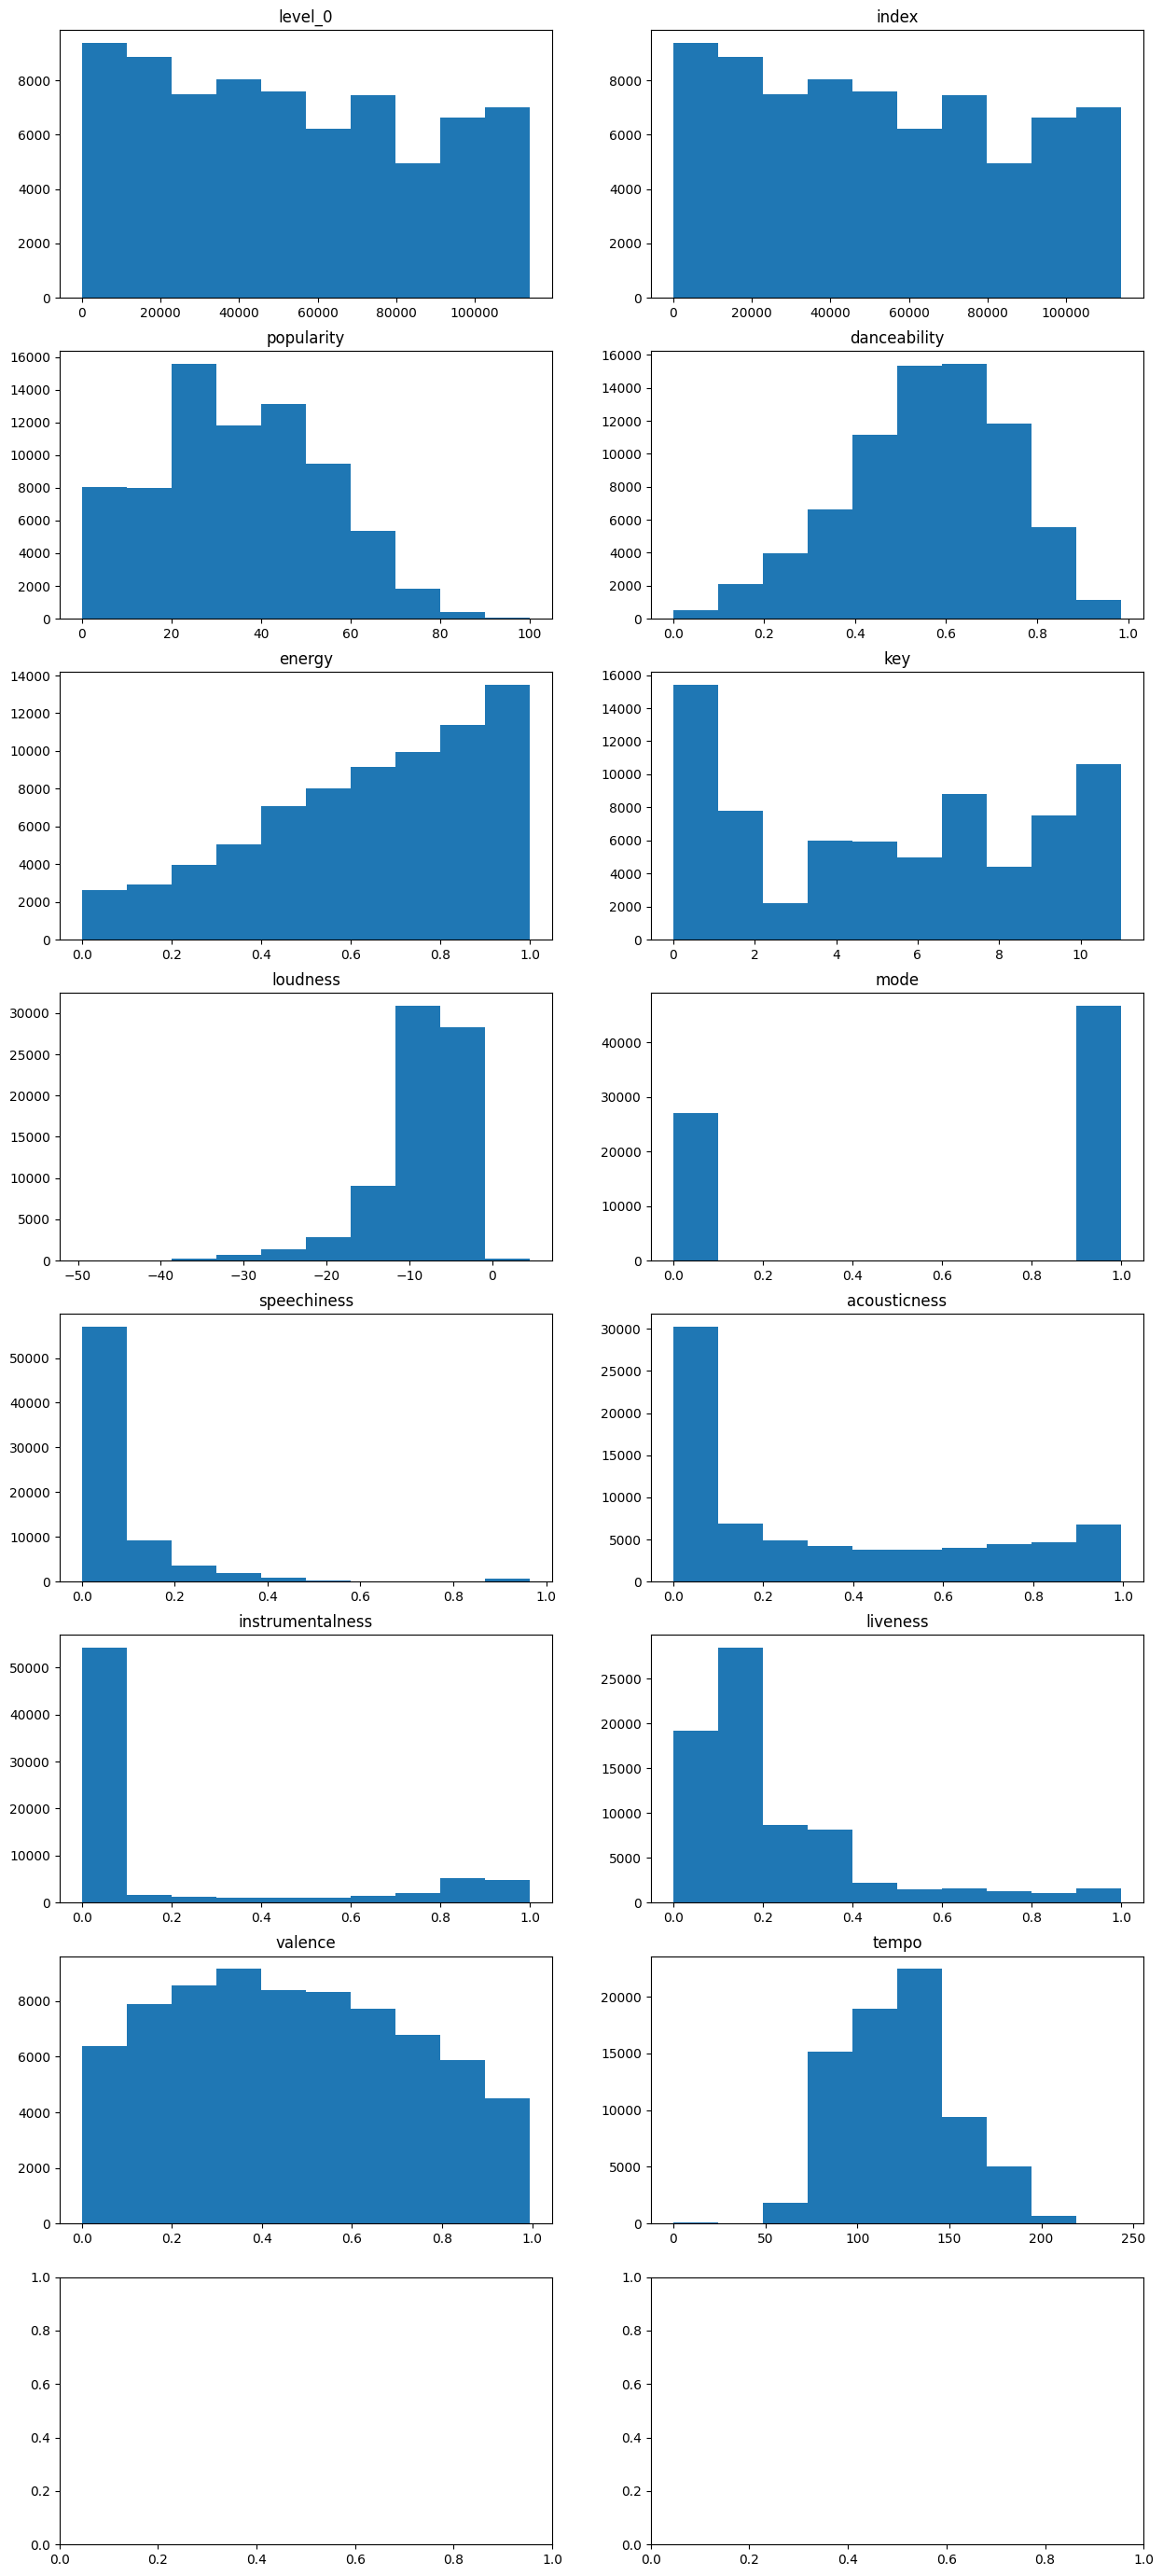

In [9]:
fig, ax = plt.subplots(8, 2, figsize=(15,35))

for i,j in enumerate(numerical):
    k = i//2
    l = i%2
    ax[k,l].hist(spotify[j], density = False)
    ax[k,l].set_title(j)
    
plt.show()

In [10]:
plt.savefig("test.svg", transparent=True)

<Figure size 640x480 with 0 Axes>

In [41]:
spotify['mode'] = spotify['mode'].astype("category")
spotify['key'] = spotify['key'].astype("category")

In [42]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73608 entries, 0 to 73607
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   level_0           73608 non-null  int64   
 1   index             73608 non-null  int64   
 2   track_id          73608 non-null  object  
 3   artists           73608 non-null  object  
 4   album_name        73608 non-null  object  
 5   track_name        73608 non-null  object  
 6   popularity        73608 non-null  float64 
 7   danceability      73608 non-null  float64 
 8   energy            73608 non-null  float64 
 9   key               73608 non-null  category
 10  loudness          73608 non-null  float64 
 11  mode              73608 non-null  category
 12  speechiness       73608 non-null  float64 
 13  acousticness      73608 non-null  float64 
 14  instrumentalness  73608 non-null  float64 
 15  liveness          73608 non-null  float64 
 16  valence           7360

In [43]:
spotify.to_csv("spotify_new2.csv",mode='w+')

In [44]:
spotify_new = pd.read_csv("spotify_new2.csv")
 

In [45]:
spotify_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73608 entries, 0 to 73607
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        73608 non-null  int64  
 1   level_0           73608 non-null  int64  
 2   index             73608 non-null  int64  
 3   track_id          73608 non-null  object 
 4   artists           73608 non-null  object 
 5   album_name        73608 non-null  object 
 6   track_name        73608 non-null  object 
 7   popularity        73608 non-null  float64
 8   danceability      73608 non-null  float64
 9   energy            73608 non-null  float64
 10  key               73608 non-null  int64  
 11  loudness          73608 non-null  float64
 12  mode              73608 non-null  int64  
 13  speechiness       73608 non-null  float64
 14  acousticness      73608 non-null  float64
 15  instrumentalness  73608 non-null  float64
 16  liveness          73608 non-null  float6

In [13]:
spotify_no_children = spotify_new[spotify_new.track_genre!='children'].drop(columns=['level_0']).reset_index()
#spotify_no_children.to_csv("spotify_no_children.csv",mode='w+')

In [14]:
spotify_no_children

,level_0,Unnamed: 0,index,track_id,artists,album_name,track_name,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,Genre_Combined
0,0,0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,acoustic,"['acoustic', 'j-pop', 'singer-songwriter', 'so..."
1,1,1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,acoustic,"['acoustic', 'chill']"
2,2,2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,acoustic,['acoustic']
3,3,3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,acoustic,['acoustic']
4,4,4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,acoustic,['acoustic']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72829,73603,73603,113994,4WbOUe6T0sozC7z5ZJgiAA,Lucas Cervetti,Frecuencias Álmicas en 432hz,"Frecuencia Álmica, Pt. 4",22,0.331,0.1710,1,-15.668,1,0.0350,0.9200,0.022900,0.0679,0.3270,132.147,world-music,['world-music']
72830,73604,73604,113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,world-music,['world-music']
72831,73605,73605,113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,world-music,['world-music']
72832,73606,73606,113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,world-music,['world-music']


In [16]:
spotify_dummies = pd.get_dummies(spotify_original['track_genre'])
dummies_cols = list(spotify_dummies.columns)

In [17]:
spotify_dummies = spotify_original.join(spotify_dummies)

In [18]:
mlb = MultiLabelBinarizer(sparse_output=True)

genre_dummies = pd.DataFrame.sparse.from_spmatrix(mlb.fit_transform(spotify.pop('Genre_Combined')),index=spotify.index,columns=mlb.classes_)

In [24]:
#genre_dummies_norm = genre_combined_dummies.div(genre_combined_dummies.sum(axis=1), axis=0)

In [25]:
# genre dummies one hot encodes the list of genres
# genre dummies norm normalizes the dummy rows by dividing the row by the sum of the row

spotify_ohe = spotify.join(genre_dummies)
spotify_ohe_norm = spotify.join(genre_dummies_norm)

NameError: name 'genre_dummies_norm' is not defined

In [24]:
spotify_ohe.head(5)

,level_0,index,track_id,artists,album_name,track_name,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,acoustic,afrobeat,alt-rock,alternative,ambient,anime,black-metal,bluegrass,blues,brazil,breakbeat,british,cantopop,chicago-house,children,chill,classical,club,comedy,country,dance,dancehall,death-metal,deep-house,detroit-techno,disco,disney,drum-and-bass,dub,dubstep,edm,electro,electronic,emo,folk,forro,french,funk,garage,german,gospel,goth,grindcore,groove,grunge,guitar,happy,hard-rock,hardcore,hardstyle,heavy-metal,hip-hop,honky-tonk,house,idm,indian,indie,indie-pop,industrial,iranian,j-dance,j-idol,j-pop,j-rock,jazz,k-pop,kids,latin,latino,malay,mandopop,metal,metalcore,minimal-techno,mpb,new-age,opera,pagode,party,piano,pop,pop-film,power-pop,progressive-house,psych-rock,punk,punk-rock,r-n-b,reggae,reggaeton,rock,rock-n-roll,rockabilly,romance,sad,salsa,samba,sertanejo,show-tunes,singer-songwriter,ska,sleep,songwriter,soul,spanish,study,swedish,synth-pop,tango,techno,trance,trip-hop,turkish,world-music
0,0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.715,87.917,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.267,77.489,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.120,76.332,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.143,181.740,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.167,119.949,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
num_features = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

scaler = StandardScaler()
scaled = scaler.fit_transform(spotify[num_features])
spotify[num_features] = pd.DataFrame(scaled,columns=num_features)

scaled_dummies = scaler.fit_transform(spotify_original[num_features])
spotify_dummies[num_features] = pd.DataFrame(scaled_dummies,columns=num_features)

In [23]:
#spotify.to_csv("/Users/scottsmacbook/DataMining/FinalProject/Spotify/spotify_scaled.csv",mode="w+")

In [24]:
#spotify_dummies.to_csv("/Users/scottsmacbook/DataMining/FinalProject/Spotify/spotify_scaled_w_dups_OH.csv",mode='w+')

# 1. Content-based recommender system.

In [25]:
train=spotify.sample(frac=0.7,random_state=200)
test=spotify.drop(train.index)

In [26]:
train_dummies=spotify_dummies.sample(frac=0.7,random_state=200)
test_dummies=spotify_dummies.drop(train_dummies.index)

In [27]:
train_numerical = train[num_features]
train_labels = train.drop(columns=num_features)

test_numerical = test[num_features]
test_labels = test.drop(columns=num_features)

In [28]:
num_dummy_features = num_features+dummies_cols

train_numerical_dummies = train_dummies[num_dummy_features]
train_labels_dummies = train_dummies.drop(columns=num_dummy_features)

test_numerical_dummies = test_dummies[num_dummy_features]
test_labels_dummies = test_dummies.drop(columns=num_dummy_features)

In [35]:
train_numerical

,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
70361,-0.957962,0.573166,-1.994505,-1.850426,-0.319708,1.247297,-0.556349,-0.534996,0.180937,-0.642354
31712,-1.010063,-1.174624,1.233386,0.065838,0.332424,-0.973476,0.677796,0.543053,-1.626552,-0.644509
18045,0.917688,-1.510737,1.360955,0.864376,0.164781,-0.974488,-0.016222,-0.500220,-1.019511,0.473150
27486,-0.072238,-0.132672,0.645794,0.032942,0.256984,0.935362,-0.556349,2.321585,0.461168,-0.857898
29200,-0.541151,0.802844,-0.819321,0.048168,-0.416103,-0.368292,-0.523458,-0.534996,0.222593,0.263009
...,...,...,...,...,...,...,...,...,...,...
38804,-1.062164,0.724417,-1.689112,-1.372957,-0.360780,1.320867,-0.556349,-0.445573,1.127663,0.491049
1568,-0.801657,1.077337,0.893201,0.723955,-0.489027,1.108986,1.214905,-0.530028,1.960782,0.925020
57322,0.605080,0.545157,-0.278117,-0.487010,-0.486513,0.440974,2.313263,0.448661,-0.974068,0.026186
70676,-0.436948,1.032521,0.556882,0.283707,-0.444602,-0.538973,-0.551551,-0.296534,1.555583,0.356678


In [29]:
train_numerical.columns

Index(['popularity', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

In [3]:
from spotify_utils import get_playlist_df
from spotify_utils import get_track_features
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from etl_utils import get_unique_map_from_df_col, clean_date
import json

file = open('credentials.json')
credentials = json.load(file)
file.close()

auth_manager = SpotifyClientCredentials(client_id = credentials["client_id"], 
                                        client_secret = credentials["client_secret"])

sp = spotipy.Spotify(auth_manager=auth_manager)

In [31]:
# https://medium.com/analytics-vidhya/build-your-own-playlist-generator-with-spotifys-api-in-python-ceb883938ce4
# import requests

# user_id ='spotify:user:scottmatsubara'

# endpoint_url = f"https://api.spotify.com/v1/users/{user_id}/playlists"
# request_body = json.dumps({
#           "name": "Test Python",
#           "description": "My first programmatic playlist, yooo!",
#           "public": False # let's keep it between us - for now
#         })
# response = requests.post(url = endpoint_url, data = request_body, headers={"Content-Type":"application/json", 
#                         "Authorization":"Bearer "+ token})

In [39]:
def get_distance_recs_song(features,data,data_labels):
    # Get the index of the track with the given ID
    data_new = data.copy()
    features = np.array(features)
    
    distances = []
    for j in range(len(data_new)):
        dist = np.linalg.norm(features - np.array(data_new.iloc[j]))
        if dist==0:
            distances.append(1000000)
        else:
            distances.append(dist)
    
    data_new['Distance'] = distances
    data_new = data_new.join(data_labels)
    data_new = data_new.sort_values(by=['Distance'])
    return data_new

In [40]:
recs = get_distance_recs_song(test_numerical.iloc[4],train_numerical,train_labels)

In [41]:
test_labels.iloc[4]

level_0                            26
index                              26
track_id       5IfCZDRXZrqZSm8AwE44PG
artists                    Jason Mraz
album_name      Holly Jolly Christmas
track_name          Winter Wonderland
track_genre                  acoustic
Name: 23, dtype: object

In [42]:
display_labels = ['Distance','artists','album_name','track_name','track_genre']
recs[display_labels].head(10)

,Distance,artists,album_name,track_name,track_genre
45643,0.647351,Sammy Davis Jr.,christmas but not christmas songs,Something's Gotta Give - Single Version,jazz
51081,0.675401,Milton Nascimento,Chill in Brazil,Rosa Maria,mpb
60786,0.765143,"Группа ""Загадка""",Золотая коллекция эстрады. Сиреневый туман,Люблю (Вдыхая розы аромат),romance
64195,0.815612,Krystina Alabado;Shereen Pimentel,Teen Time Travelers: The French Correction,Turbulent Flow,show-tunes
61190,0.824052,"Группа ""Загадка""","20 лучших ресторанных песен. Ой, цветет калина","А за окном то дождь, то снег",romance
68839,0.842305,Junie,LUGNA HITS,Salt I Mina Sår,swedish
45524,0.896937,Dean Martin,All I Want For Christmas Is You,I've Got My Love To Keep Me Warm - Remastered ...,jazz
61096,0.956325,"Группа ""Загадка""",Золотая коллекция эстрады. Сиреневый туман,Сиреневый туман,romance
16034,0.957696,Maddie & Tae,Country Christmas Greatest Hits,Holly Jolly Christmas,country
39030,0.977398,Hank Williams,Low Down Blues,Honky Tonk Blues - Non-Session Demo,honky-tonk


In [43]:
recs = get_distance_recs_song(test_numerical_dummies.iloc[4],train_numerical_dummies,train_labels_dummies)

In [44]:
display_labels = ['Distance','artists','album_name','track_name','track_genre']
recs[display_labels].head(10)

,Distance,artists,album_name,track_name,track_genre
18,0.269000,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,acoustic
75,1.084376,Jason Mraz,Love Is a Four Letter Word,93 Million Miles,acoustic
903,1.117485,Zack Tabudlo,Yakap,Yakap,acoustic
20,1.209542,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,acoustic
583,1.310534,Joshua Hyslop,Ash & Stone,Gentle Heart,acoustic
590,1.318176,The Weepies;Deb Talan;Steve Tannen,Hideaway,Can't Go Back Now,acoustic
162,1.370006,Jason Mraz,I'm Yours,I'm Yours,acoustic
338,1.459133,Joshua Hyslop,Echos,Stand Your Ground,acoustic
5,1.522267,Tyrone Wells,Days I Will Remember,Days I Will Remember,acoustic
19302,1.539808,Shania Twain,Come On Over,You're Still The One,country


In [45]:
recs_genre = get_distance_recs_song(test_numerical_dummies.iloc[4],train_numerical_dummies,train_labels_dummies)

In [46]:
# recommendations are better if genre is not included.
recs_genre[display_labels].head(10)

,Distance,artists,album_name,track_name,track_genre
18,0.269000,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,acoustic
75,1.084376,Jason Mraz,Love Is a Four Letter Word,93 Million Miles,acoustic
903,1.117485,Zack Tabudlo,Yakap,Yakap,acoustic
20,1.209542,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,acoustic
583,1.310534,Joshua Hyslop,Ash & Stone,Gentle Heart,acoustic
590,1.318176,The Weepies;Deb Talan;Steve Tannen,Hideaway,Can't Go Back Now,acoustic
162,1.370006,Jason Mraz,I'm Yours,I'm Yours,acoustic
338,1.459133,Joshua Hyslop,Echos,Stand Your Ground,acoustic
5,1.522267,Tyrone Wells,Days I Will Remember,Days I Will Remember,acoustic
19302,1.539808,Shania Twain,Come On Over,You're Still The One,country


In [47]:
test.iloc[4]

level_0                                 26
index                                   26
track_id            5IfCZDRXZrqZSm8AwE44PG
artists                         Jason Mraz
album_name           Holly Jolly Christmas
track_name               Winter Wonderland
popularity                       -1.791584
danceability                      0.343489
energy                           -1.267746
loudness                         -0.113682
speechiness                       -0.34234
acousticness                      1.344409
instrumentalness                 -0.556349
liveness                         -0.380989
valence                           0.745186
tempo                             0.769602
track_genre                       acoustic
Name: 23, dtype: object

In [48]:
# find distance from all songs in the playlist to all songs in corpus. Then get the average of all these distances to 
# find the songs with the closest average distance to all songs in the playlist

def get_distance_recs_playlist(uri, data, data_labels, OH = False):
    # Get the index of the track with the given ID
    
    df_original = get_playlist_df('spotify', uri, sp, song_limit=10)
    genre = df_original['track_genre']
    df = df_original[num_features]
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df),columns=num_features)
    if(OH):
        for col in dummies_cols:
            df[col] = 0
        for i in range(len_df):
            df.loc[i,lower(genre)] = 1
        
    
    data_new = data.copy()
    all_distances = []
    
    for i in range(len(df)):
        features = np.array(df.iloc[i])
        distances = []
        for j in range(len(data_new)):
            dist = np.linalg.norm(features - np.array(data_new.iloc[j]))
            if dist==0:
                distances.append(1000000)
            else:
                distances.append(dist)
        all_distances.append(distances)

    all_distances = np.array(all_distances)
    avg_dist = np.sum(all_distances, 0) / len(all_distances)
    
    data_new['Distance'] = avg_dist.tolist()

    data_new = data_new.join(data_labels)
    return data_new.sort_values(by=['Distance']),df_original

In [49]:
test_small = test_numerical.head(10)
playlist_recs,playlist = get_distance_recs_playlist('spotify:playlist:6mQ256r9AwXBIdfd36Gbob',train_numerical,train_labels)

Got track 1 out of 204
Got track 2 out of 204
Got track 3 out of 204
Got track 4 out of 204
Got track 5 out of 204
Got track 6 out of 204
Got track 7 out of 204
Got track 8 out of 204
Got track 9 out of 204
Got track 10 out of 204
Got track 11 out of 204
Got track 12 out of 204


In [50]:
playlist_recs.head(10)

,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Distance,level_0,index,track_id,artists,album_name,track_name,track_genre
62015,-0.072238,0.545157,-0.274252,0.159264,-0.488189,0.158467,-0.556330,0.180391,-0.099294,-0.262344,3.095061,95313,95314,0JWnqFLENqVGs4yNss52gy,Willie Colón,Fantasmas,Celo,salsa
27606,-0.020137,0.281868,-0.285849,-0.337378,-0.116860,-0.056357,-0.556349,-0.564804,-0.262130,-0.210107,3.101856,36643,36643,0SwrpK6ZkaoGvBrdbrklFh,Lynda Lemay,Lynda Lemay,Les Souliers verts,french
13536,0.188269,0.097006,0.131651,0.171671,-0.235048,0.605770,-0.556349,-0.321374,0.025674,-0.199600,3.104133,16307,16307,4piMfKVoPcY06x4hTLf9Pl,Rahul Deshpande,Katyar Kaljat Ghusli (Original Motion Picture ...,Dil Ki Tapish,classical
71172,-0.228542,0.343489,-0.200803,0.257766,-0.495733,-0.256466,-0.556349,-0.236918,-0.288639,0.066060,3.109214,110798,110799,3xWwecwIKqwgbMamxQ3vtG,Deny,Invencible,Un Año Más,trance
17165,-0.228542,0.326683,-0.146682,0.448941,-0.167153,-0.324150,-0.556349,-0.505188,-0.046277,-0.073349,3.110256,21531,21531,4MP0DR7DuBXd0w7QV99V92,Malie Donn;Moonskull;Harlem Richard$,We Rising,We Rising,dancehall
64825,0.084066,0.001774,0.135517,0.061139,-0.407720,-0.474232,-0.555631,-0.162399,0.264249,-0.231485,3.116248,99613,99614,1ODitWwCi2P2D489FX5CmY,Jasleen Royal,Jahaan Tu Chala - Midnight Mix (Gully Boy),Jahaan Tu Chala - Midnight Mix (Gully Boy),singer-songwriter
5968,-0.436948,0.040987,-0.200803,0.112645,-0.495733,0.158467,-0.556239,-0.505188,0.199872,0.023402,3.118438,7326,7326,3spGkhIhKBYRZcC3crNiZz,Trampled by Turtles,Sigourney Fever,Pocahontas,bluegrass
12317,-0.280644,-0.054245,-0.459807,0.054748,-0.384250,0.134924,-0.556349,-0.187238,0.453594,-0.112792,3.121258,14789,14789,1ODuiU1H47mNBcxvfQkmUz,Rolf Zuckowski,Rolfs fröhlicher Familientag,Der Morgenmuffel,children
30936,-0.645353,0.253859,0.004082,-0.149022,-0.478969,0.376233,-0.555552,-0.077943,0.124134,-0.475600,3.125234,41592,41592,5UYQSCJ9VDdC9P0akTVaED,Arvid Nero,Mother Earth,Bored With Clay,goth
36172,-0.332745,0.393906,-0.138951,0.195544,-0.443764,-0.041643,-0.331246,-0.660686,-0.515853,-0.071659,3.125306,48971,48971,5X65C51a9CkEjc3Hvamf33,Gloria,Acima do Céu,Voltar pra Casa,hardcore


In [51]:
# get recommendations by taking the average of all features and treating it as one song, takes much less time 

def get_distance_recs_playlist_2(uri, data, data_labels):
    # Get the index of the track with the given ID
    df = get_playlist_df('spotify', uri, sp, song_limit=10)
    df = df[num_features]
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df),columns=num_features)
    
    return(get_distance_recs_song(df.mean(axis=0),data,data_labels))

In [52]:
playlist_recs_2 = get_distance_recs_playlist_2('spotify:playlist:6mQ256r9AwXBIdfd36Gbob',train_numerical,train_labels)

Got track 1 out of 204
Got track 2 out of 204
Got track 3 out of 204
Got track 4 out of 204
Got track 5 out of 204
Got track 6 out of 204
Got track 7 out of 204
Got track 8 out of 204
Got track 9 out of 204
Got track 10 out of 204
Got track 11 out of 204
Got track 12 out of 204


In [53]:
playlist_recs

,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Distance,level_0,index,track_id,artists,album_name,track_name,track_genre
62015,-0.072238,0.545157,-0.274252,0.159264,-0.488189,0.158467,-0.556330,0.180391,-0.099294,-0.262344,3.095061,95313,95314,0JWnqFLENqVGs4yNss52gy,Willie Colón,Fantasmas,Celo,salsa
27606,-0.020137,0.281868,-0.285849,-0.337378,-0.116860,-0.056357,-0.556349,-0.564804,-0.262130,-0.210107,3.101856,36643,36643,0SwrpK6ZkaoGvBrdbrklFh,Lynda Lemay,Lynda Lemay,Les Souliers verts,french
13536,0.188269,0.097006,0.131651,0.171671,-0.235048,0.605770,-0.556349,-0.321374,0.025674,-0.199600,3.104133,16307,16307,4piMfKVoPcY06x4hTLf9Pl,Rahul Deshpande,Katyar Kaljat Ghusli (Original Motion Picture ...,Dil Ki Tapish,classical
71172,-0.228542,0.343489,-0.200803,0.257766,-0.495733,-0.256466,-0.556349,-0.236918,-0.288639,0.066060,3.109214,110798,110799,3xWwecwIKqwgbMamxQ3vtG,Deny,Invencible,Un Año Más,trance
17165,-0.228542,0.326683,-0.146682,0.448941,-0.167153,-0.324150,-0.556349,-0.505188,-0.046277,-0.073349,3.110256,21531,21531,4MP0DR7DuBXd0w7QV99V92,Malie Donn;Moonskull;Harlem Richard$,We Rising,We Rising,dancehall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66093,0.188269,-3.129684,-2.462181,-6.474348,-0.757256,1.891767,-0.553181,-0.604548,-1.769318,-4.048497,9.532550,101442,101443,2QNQCdk29G9JCPTB0uOvsg,White Noise Babies,Loopable White Noise For Baby Sleep,Clean White Noise - Loopable Without Fade,sleep
66097,0.188269,-3.129684,-2.462181,-6.474348,-0.757256,1.891767,-0.553181,-0.604548,-1.769318,-4.048497,9.532550,101446,101447,3FCjw9jRcPqw8A9k2ZkJ5p,White Noise Sleep Sounds;Sleep Sound Library,Loopable White Noise Sleep Sounds,Clean White Noise - Loopable With No Fade,sleep
66534,-0.124340,-3.129684,-2.459793,-6.440136,-0.757256,1.909424,1.957202,-0.617961,-1.769318,-4.048497,9.703986,101938,101939,1gMuHUxFRYRDAmdfG3mmNM,White Noise Babies,Loopable White Noise For Baby Sleep,Air Conditioner - Loopable Without Fade,sleep
66182,0.084066,-3.129684,-2.461266,-6.464761,-0.757256,1.900595,2.307228,-0.612000,-1.769318,-4.048497,9.796908,101539,101540,4YukH0BeXhJmcCmz2BBRke,Baby Sleep White Noise,Relaxing Loopable White Noise,Box Fan - Loopable With No Fade,sleep


In [54]:
# Gets n number of recs from each song then finds recs based on all songs. 


def get_distance_recs_playlist_3(uri, data, data_labels):
    # Get the index of the track with the given ID
    
    df_original = get_playlist_df('spotify', uri, sp, song_limit=10)
    genre = df_original['track_genre']
    df = df_original[num_features]
    
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df),columns=num_features)
    
    recs = []
    
    for i in range(len(df)):
        song_recs = get_distance_recs_song(df.iloc[i],data,data_labels)
        recs.extend([list(song_recs.iloc[i,:]) for i in range(2)])

    song_recs = get_distance_recs_song(df.mean(axis=0),data,data_labels)
    recs.extend([list(song_recs.iloc[i,:]) for i in range(5)])
    print(df.mean(axis=0))
    
    data_cols = list(data.columns)
    data_cols.append('Distance') 
    cols = data_cols + list(data_labels.columns)
    
    return pd.DataFrame(recs,columns=cols)

In [55]:
playlist_recs_4

NameError: name 'playlist_recs_4' is not defined

-------------

# Generate Actual Playist

In [ ]:
# https://community.spotify.com/t5/Spotify-for-Developers/Redirect-URI-needed/td-p/5067419
def create_playlist(recs,playlist_name,Public=False):
    uris = list(recs.track_id)
    uris = ["spotify:track:" + x for x in uris]
    
    auth_manager = SpotifyOAuth(client_id=credentials["client_id"], client_secret=credentials["client_secret"], redirect_uri = 'http://localhost/',scope='playlist-modify-private playlist-modify-public')
    sp = spotipy.Spotify(auth_manager=auth_manager)

    # Create a new playlist
    playlist_name = playlist_name + " Playlist Recs"
    playlist_description = "Playlist Consisting of Songs Recommended by Data Mining Team 4's Program"
    user_id = sp.me()["id"]
    new_playlist = sp.user_playlist_create(user=user_id, name=playlist_name, public=Public, description=playlist_description)

    sp.playlist_add_items(playlist_id=new_playlist["id"], items=uris)
    return new_playlist

In [16]:
data = pd.read_csv("spotify_scaled.csv")

data_numerical = data[num_features]
data_labels = data.drop(columns=num_features)

NameError: name 'num_features' is not defined

In [ ]:
playlist_recs_3 = get_distance_recs_playlist_3('spotify:playlist:0e8d3aaHBKZ4i0wT5TpTK6',data_numerical,data_labels)

In [17]:
results = sp.user_playlist(user=None, playlist_id='spotify:playlist:0e8d3aaHBKZ4i0wT5TpTK6', fields="name")
playlist_name = results['name']
playlist = create_playlist(playlist_recs_4,playlist_name)

NameError: name 'sp' is not defined

In [18]:
playlist_recs_3 = get_distance_recs_playlist_3('spotify:playlist:0SqojhPLvEpsg9giftSUx7',data_numerical,data_labels)

NameError: name 'get_distance_recs_playlist_3' is not defined

In [19]:
uri = 'spotify:playlist:0SqojhPLvEpsg9giftSUx7'
df_original = get_playlist_df('spotify', uri, sp, song_limit=10)
genre = df_original['track_genre']
df = df_original[num_features]

scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df),columns=num_features)

NameError: name 'get_playlist_df' is not defined

In [20]:
df_original

NameError: name 'df_original' is not defined

In [21]:
test = playlist_recs_2.mean(axis=0)

NameError: name 'playlist_recs_2' is not defined

In [436]:
list(test.index)

['popularity',
 'danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'Distance',
 'level_0',
 'index']

In [441]:
data = pd.DataFrame(playlist_recs_2.mean(axis=0)).T
data.columns=list(test.index)

popularity              0.002174
danceability           -0.000444
energy                  0.004281
loudness                0.005456
speechiness            -0.002719
acousticness           -0.003676
instrumentalness       -0.001223
liveness                0.000057
valence                -0.000209
tempo                  -0.003109
Distance                2.974775
level_0             52826.738287
index               52827.108858
Name: 0, dtype: float64

In [443]:
data.iloc[0]

popularity              0.002174
danceability           -0.000444
energy                  0.004281
loudness                0.005456
speechiness            -0.002719
acousticness           -0.003676
instrumentalness       -0.001223
liveness                0.000057
valence                -0.000209
tempo                  -0.003109
Distance                2.974775
level_0             52826.738287
index               52827.108858
Name: 0, dtype: float64

In [430]:
isinstance(pd.DataFrame(test), pd.DataFrame)

True

## Program in Action

# tried including genres but it dominated the suggestions.

In [56]:
#! pip install gower
import gower 

weights = [1 for i in range(10)]
weights.append(0.5)
weights

cat_features = [False]*10
cat_features.append(True)

def get_distance_recs_song_gower(features,data,data_labels):
    # Get the index of the track with the given ID
    data_new = data.copy()
    #features = np.array(features)
    

    gower_closest = gower.gower_topn(features, data, n = 5)
    
    top_5 = list(gower_closest['index'])
    top_5_df = data.iloc[top_5]
    top_5_df = top_5_df.join(data_labels.iloc[top_5])
    
    return top_5_df

In [70]:
def get_distance_recs_playlist_gower(uri,data,data_labels,scaler,sp):
    # Get the index of the track with the given ID
    df_original = get_playlist_df('spotify', uri, sp, song_limit=8)
    ids = list(df_original['track_id'])
    genres = list(df_original['track_genre'])
    playlist_genre = [mode(genres)]
    data = data[~data_labels['track_id'].isin(ids)]
    data_labels = data_labels[~data_labels['track_id'].isin(ids)]
    #genre = df_original['track_genre']
    

    df_num = df_original[num_features]

    df_combined = pd.DataFrame(df_num.mean(axis=0)).T
    df_combined.columns=num_features

    df_combined = pd.DataFrame(scaler.transform(df_combined),columns=num_features)
    df = pd.DataFrame(scaler.transform(df_num),columns=num_features)
    
    df_combined['Genre'] = playlist_genre
    df['Genre'] = df_original.track_genre

    recs = []
    
    for i in range(len(df)):
        song_recs = get_distance_recs_song_gower(df.iloc[i:i+1,:],data,data_labels)
        recs.extend([list(song_recs.iloc[i,:]) for i in range(3)])

    song_recs = get_distance_recs_song_gower(df_combined.iloc[0:1,:],data,data_labels)
    recs.extend([list(song_recs.iloc[i,:]) for i in range(5)])
     
    cols = list(data.columns) + list(data_labels.columns)
    
    final_recs = pd.DataFrame(recs,columns=cols)

    return final_recs

In [71]:
from statistics import mode
train_numerical = train[num_features]
train_labels = train.drop(columns=num_features)

train_numerical['Genre'] = train.track_genre
train_labels.drop(columns=['track_genre'],inplace=True)
recs = get_distance_recs_playlist_gower('spotify:playlist:0SqojhPLvEpsg9giftSUx7',train_numerical,train_labels,scaler,sp)

Got track 1 out of 157
Got track 2 out of 157
Got track 3 out of 157
Got track 4 out of 157
Got track 5 out of 157
Got track 6 out of 157
Got track 7 out of 157
Got track 8 out of 157
Got track 9 out of 157
Got track 10 out of 157


In [72]:
recs['title_stripped'] = recs['track_name'].str.split('(').str[0]
recs['title_stripped'] = recs['title_stripped'].str.split('-').str[0] 
recs['title_stripped'] = recs['title_stripped'].str.strip()

In [73]:
recs

,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Genre,level_0,index,track_id,artists,album_name,track_name,title_stripped
0,1.490803,1.368635,0.858409,0.789372,0.793442,-0.076956,-0.556162,1.640974,0.620218,-0.700591,pop-film,80469,80470,6VbmeIWTbNHM5uqoW7GTE4,Sunidhi Chauhan;Vishal Dadlani,Tees Maar Khan,Sheila Ki Jawani,Sheila Ki Jawani
1,1.699208,1.525488,0.174174,0.546502,1.237696,-0.221153,-0.556349,1.347864,0.502824,-1.006721,hardcore,48109,48109,2KFg8kjYy0rYjWsXGhEQHN,The Notorious B.I.G.,Ready to Die (The Remaster),Who Shot Ya? - 2005 Remaster,Who Shot Ya?
2,2.376526,0.914882,0.417715,0.834675,1.388575,-0.247638,-0.556349,0.975266,0.199872,-1.495348,rock,91064,91065,5UlnuulVAVmmesw4VzqHdG,Imagine Dragons;Arcane;League of Legends,Enemy (from the series Arcane League of Legends),Enemy - From the series Arcane League of Legends,Enemy
3,1.907614,0.752427,0.719243,0.910431,-0.148712,-0.700238,-0.556349,0.523181,1.036777,-1.134893,power-pop,82106,82107,1yKu2MhpwzDXXH2tzG6xoa,Weezer,Make Believe,Beverly Hills,Beverly Hills
4,1.959715,0.589972,0.738572,0.479582,-0.418617,-0.949816,-0.556349,0.354270,1.335943,-0.601884,groove,43130,43130,6GqqGv8frU7kqzXkm2rewI,Five Finger Death Punch,F8,A Little Bit Off,A Little Bit Off
5,1.751310,0.573166,0.437044,1.111005,-0.176373,-0.806473,-0.556346,0.140647,0.760333,-0.964295,spanish,104103,104104,0cUp7d3a6DHzAuSKBn1NZJ,Beret;Omar Montes,Tú y yo,Tú y yo,Tú y yo
6,1.647107,0.791640,0.359729,-0.029843,-0.496571,-0.586058,-0.556349,-0.445573,1.869896,0.277593,disco,25416,25416,5CI1FP2Volc9wjz2MBZsGx,Irene Cara,Fame (Original Motion Picture Soundtrack),Fame,Fame
7,1.803411,1.295810,0.046605,0.206259,-0.535129,-0.486003,-0.556081,-0.649259,1.843388,-0.276629,disco,25353,25353,4JEylZNW8SbO4zUyfVrpb7,Billy Ocean,The Very Best of Billy Ocean,Caribbean Queen (No More Love On the Run),Caribbean Queen
8,2.063918,1.346227,0.193503,0.549322,-0.395985,-0.406548,-0.555782,-0.953796,1.885044,-0.442157,synth-pop,107127,107128,4d6eqRtpDX7tydHJGDZUBQ,Fine Young Cannibals,The Raw & The Cooked,She Drives Me Crazy,She Drives Me Crazy
9,1.490803,0.192238,0.645794,0.693126,-0.447116,0.237922,-0.556349,-0.564804,0.487676,0.208187,spanish,104316,104317,1EC0JRoSi9YL5zExd3Euc3,Los Ronaldos,4 Canciones,No Puedo Vivir Sin Ti,No Puedo Vivir Sin Ti


In [93]:
train_numerical = train[num_features]
train_labels = train.drop(columns=num_features)

test_numerical = test[num_features]
test_labels = test.drop(columns=num_features)

test_numerical['Genre'] = test_labels.track_genre
train_numerical['Genre'] = train_labels.track_genre

test_labels.drop(columns=['track_genre'],inplace=True)
train_labels.drop(columns=['track_genre'],inplace=True)


recs = get_distance_recs_song_gower(test_numerical.iloc[4:5,:],train_numerical,train_labels)

recs

,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Genre,level_0,index,track_id,artists,album_name,track_name
654,-0.384846,0.153025,-0.857978,0.144790,-0.525909,1.485663,-0.556168,-0.500220,0.896662,0.592009,acoustic,723,723,20GlDn5GNOkgZUui7Z57k1,Suy Galvez,Bossa Best,Your Song
29,-1.791584,0.265062,-1.202029,-0.268201,-0.510821,1.500377,-0.556349,-0.415765,-0.201540,-1.011527,acoustic,38,38,1ae8XfBQ3fDEvmBjFaemGV,Brandi Carlile,Coffee Moment,This Time Tomorrow
537,-0.228542,0.612380,-1.287075,-0.152406,-0.460528,1.412093,-0.556349,-0.695958,0.377856,-0.325021,acoustic,594,594,2z3PXMMsdQqZ48OdOTBIoZ,Apes of the State,This City Isn't Big Enough,Timeline
862,-0.436948,-0.155079,-1.345061,-0.872556,-0.333957,1.538633,-0.556349,-0.650253,0.544480,0.066723,acoustic,945,945,5epYcmFhgMsZcyKk8A2Qi5,Chad Hates George,Chad Hates George,"Fry, Bacon, Fry (Die Pigs!)"
117,-0.801657,0.007375,-1.387584,-0.732511,0.014740,1.182556,-0.556349,-0.549900,0.480103,-0.661479,acoustic,147,147,1BECZPXBXzobsfmlzj0g3I,Jason Mraz,Waiting for My Rocket to Come (Expanded Edition),"Tonight, Not Again - Live"


In [6]:
recs['short_title'] = recs.track_name.str.split('(')

NameError: name 'recs' is not defined

In [4]:
spotify_new = pd.read_csv('spotify_new.csv')

In [47]:
spotify_new_2

Index(['level_0', 'index', 'track_id', 'artists', 'album_name', 'track_name',
       'track_genre'],
      dtype='object')